In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
# Step 1: Define Path and Read Sample Files
data_path = '../data/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
print("Files detected:", len(files), "→", files[:3])

# Read first 2 files (to keep it quick)
sample_files = files[:2]
df_list = []
for f in sample_files:
    print(f"Reading {f} ...")
    df_temp = pd.read_csv(os.path.join(data_path, f), low_memory=False)
    df_temp['__source'] = f
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)
print("Combined shape:", df.shape)

Files detected: 8 → ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv']
Reading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Reading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ...
Combined shape: (512212, 80)


In [3]:
# Step 2: Initial Inspection
print("\n--- Basic Info ---\n")
print(df.info())
print("\nColumns:\n", df.columns.tolist()[:15])


--- Basic Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512212 entries, 0 to 512211
Data columns (total 80 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             512212 non-null  int64  
 1    Flow Duration                512212 non-null  int64  
 2    Total Fwd Packets            512212 non-null  int64  
 3    Total Backward Packets       512212 non-null  int64  
 4   Total Length of Fwd Packets   512212 non-null  int64  
 5    Total Length of Bwd Packets  512212 non-null  int64  
 6    Fwd Packet Length Max        512212 non-null  int64  
 7    Fwd Packet Length Min        512212 non-null  int64  
 8    Fwd Packet Length Mean       512212 non-null  float64
 9    Fwd Packet Length Std        512212 non-null  float64
 10  Bwd Packet Length Max         512212 non-null  int64  
 11   Bwd Packet Length Min        512212 non-null  int64  
 12   Bwd Packet Length Mean

In [4]:
# Step 3: Quick Summary Statistics (before cleaning)
print("\n--- Summary Statistics (sample) ---\n")
display(df.describe(include='all').T.head(10))


--- Summary Statistics (sample) ---



q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Destination Port,512212.0,NaN,NaN,NaN,8412.76909,17447.963843,0.0,80.0,146.0,5544.0,65532.0
Flow Duration,512212.0,NaN,NaN,NaN,10166633.441044,27127138.689989,-13.0,55.0,30276.0,2033680.75,119999949.0
Total Fwd Packets,512212.0,NaN,NaN,NaN,4.091019,17.841275,1.0,1.0,2.0,4.0,3119.0
Total Backward Packets,512212.0,NaN,NaN,NaN,3.984264,25.620921,0.0,1.0,1.0,4.0,3635.0
Total Length of Fwd Packets,512212.0,NaN,NaN,NaN,544.584561,2592.8158,0.0,2.0,26.0,62.0,232349.0
Total Length of Bwd Packets,512212.0,NaN,NaN,NaN,4141.029205,46193.975735,0.0,6.0,6.0,350.0,7150819.0
Fwd Packet Length Max,512212.0,NaN,NaN,NaN,282.666408,1281.867186,0.0,2.0,6.0,36.0,13929.0
Fwd Packet Length Min,512212.0,NaN,NaN,NaN,18.078026,110.274825,0.0,0.0,2.0,6.0,1472.0
Fwd Packet Length Mean,512212.0,NaN,NaN,NaN,86.143519,347.365649,0.0,2.0,6.0,33.0,3867.0
Fwd Packet Length Std,512212.0,NaN,NaN,NaN,108.468259,544.842538,0.0,0.0,0.0,6.094494,6692.644993


In [5]:
# Step 4: Missing and Infinite Value Analysis
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing Values Summary:")
print(missing.head(20))

# Check for inf/-inf
inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
inf_counts = inf_counts[inf_counts > 0]
print("\nInfinite values detected:")
print(inf_counts)


Missing Values Summary:
Flow Bytes/s    19
dtype: int64

Infinite values detected:
Flow Bytes/s       386
 Flow Packets/s    405
dtype: int64


In [6]:
# Step 5: Data Type Classification
num_cols = df.select_dtypes(include=np.number).columns.tolist()
obj_cols = df.select_dtypes(include='object').columns.tolist()
print(f"\nNumeric columns: {len(num_cols)} | Object columns: {len(obj_cols)}")


Numeric columns: 78 | Object columns: 2


In [7]:
# Step 6: Label Inspection
label_cols = [c for c in df.columns if 'label' in c.lower()]
print("\nPossible label columns:", label_cols)

if label_cols:
    label = label_cols[0]
    print("\nUnique label values (first 20):")
    print(df[label].value_counts().head(20))


Possible label columns: [' Label']

Unique label values (first 20):
 Label
BENIGN      225255
PortScan    158930
DDoS        128027
Name: count, dtype: int64


q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


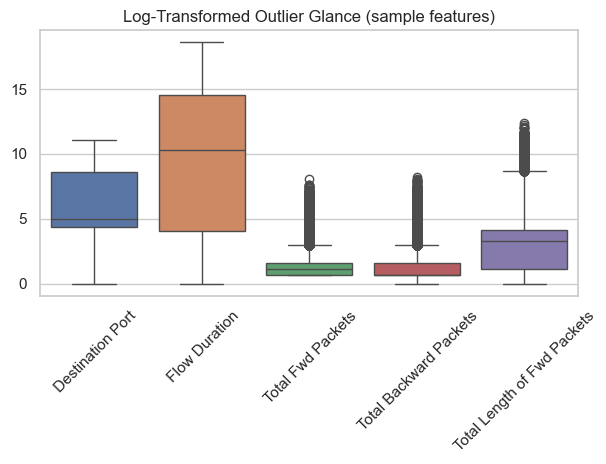

In [8]:
# Step 7: Outlier Glance on Numeric Features
numeric_sample = df.select_dtypes(include=np.number).iloc[:, :5]
sns.boxplot(data=np.log1p(numeric_sample))
plt.title("Log-Transformed Outlier Glance (sample features)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Step 8: Check for Duplicate Flow IDs (if exist)
flow_cols = [c for c in df.columns if 'flow id' in c.lower()]
if flow_cols:
    flow_col = flow_cols[0]
    dup_count = df[flow_col].duplicated().sum()
    print(f"\nDuplicate Flow IDs detected: {dup_count}")
else:
    print("\nNo Flow ID column detected or not standardised.")


No Flow ID column detected or not standardised.


In [10]:
# Step 9: Class Balance Estimation (Raw)
if label_cols:
    label = label_cols[0]
    benign_count = df[df[label].str.contains('BENIGN', case=False, na=False)].shape[0]
    total = df.shape[0]
    print(f"\nApproximate Benign percentage: {round((benign_count/total)*100, 2)}%")


Approximate Benign percentage: 43.98%


In [11]:
# Step 10: Save Profiling Summary
summary = {
    "total_rows": df.shape[0],
    "total_columns": df.shape[1],
    "num_numeric": len(num_cols),
    "num_object": len(obj_cols),
    "missing_columns": len(missing),
    "has_inf_values": len(inf_counts),
    "sample_files_analyzed": sample_files
}
pd.DataFrame([summary]).to_csv('../outputs/data_understanding_summary.csv', index=False)
print("✅ Saved raw dataset profiling summary to outputs/data_understanding_summary.csv")


✅ Saved raw dataset profiling summary to outputs/data_understanding_summary.csv
